<a href="https://colab.research.google.com/github/RobertFlan02/CS4076Project-/blob/main/DeepLabExperiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"robertflanagan02","key":"ddef6b51c20a43c6be67fb675625ab19"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d eather00/eduardopachecofoodseg103

Dataset URL: https://www.kaggle.com/datasets/eather00/eduardopachecofoodseg103
License(s): apache-2.0
100% 1.16G/1.16G [00:11<00:00, 136MB/s]
100% 1.16G/1.16G [00:11<00:00, 109MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('eduardopachecofoodseg103.zip', 'r') as zip_ref:
    zip_ref.extractall('foodseg103')

In [ ]:
# %% [code]
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Hyperparameters
HYPERPARAMS = {
    "img_size": (321, 321),         # Lower resolution than 513x513
    "batch_size": 2,                # Smaller batch size
    "num_epochs": 3,                # Adjust epochs as needed
    "learning_rate": 1e-4,
    "num_workers": 1,               # Fewer DataLoader workers
    "num_classes": 104,
    "use_amp": True,                # Mixed precision training if supported
    "flip_prob": 0.5,
    "rotation_degrees": 10,         # Maximum rotation (in degrees)
}

# Used to compute perfromance metrics such as pixel accuracy, mean IoU, and mean Dice coefficient.
#(Should be changed to ensure consitiency with validation metrics and remove as much duplicate code as possible )

def compute_metrics(preds, targets, num_classes):
    preds = preds.flatten()
    targets = targets.flatten()
    pixel_acc = np.mean(preds == targets)

    iou_list = []
    dice_list = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = np.sum(pred_inds & target_inds)
        union = np.sum(pred_inds | target_inds)
        if union == 0:
            iou = np.nan
        else:
            iou = intersection / union
        iou_list.append(iou)
        dice = (2 * intersection) / (np.sum(pred_inds) + np.sum(target_inds) + 1e-8)
        dice_list.append(dice)

    mean_iou = np.nanmean(iou_list)
    mean_dice = np.nanmean(dice_list)
    return pixel_acc, mean_iou, mean_dice

# Applies the same transformation to the image and the mask
class JointTransform:
    def __init__(self, flip_prob=0.5, rotation_degrees=0):
        self.flip_prob = flip_prob
        self.rotation_degrees = rotation_degrees

    def __call__(self, img, mask):
        # Random horizontal flip.
        if np.random.random() < self.flip_prob:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)
        # Random rotation with expand=True so that the image is not cropped to a tiny size.
        if self.rotation_degrees:
            angle = np.random.uniform(-self.rotation_degrees, self.rotation_degrees)
            img = transforms.functional.rotate(img, angle, interpolation=Image.BILINEAR, expand=True)
            mask = transforms.functional.rotate(mask, angle, interpolation=Image.NEAREST, expand=True)
        return img, mask




# Load the CSV mapping from Class Id to Class Name.
class_mappings = pd.read_csv('/content/foodseg103/class_mappings.csv')
id_to_food = dict(zip(class_mappings["Class Id"], class_mappings["Class Name"]))

# Create Training Dataset by reading and concatenating parquet files.
train_files = [
    '/content/foodseg103/train-00000-of-00003-6bb37ec387d1825a.parquet',
    '/content/foodseg103/train-00001-of-00003-4a1caa37147c0681.parquet',
    '/content/foodseg103/train-00002-of-00003-c8b698399244cd95.parquet'
]
train_dfs = [pd.read_parquet(f) for f in train_files]
full_train_df = pd.concat(train_dfs, ignore_index=True)
print("Full training data shape:", full_train_df.shape)

# Split the full training data into a training set and a testing set (80/20 split).
train_df, test_df = train_test_split(full_train_df, test_size=0.2, random_state=42)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)


# Define transforms.
img_transform = transforms.Compose([
    transforms.Resize(HYPERPARAMS["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
mask_resize = transforms.Resize(HYPERPARAMS["img_size"], interpolation=Image.NEAREST)
# Use joint augmentation for training only.
joint_transform = JointTransform(
    flip_prob=HYPERPARAMS["flip_prob"],
    rotation_degrees=HYPERPARAMS["rotation_degrees"]
)

class FoodSegDataset(Dataset):
    def __init__(self, dataframe, img_transform=None, mask_resize=None, joint_transform=None):

        self.df = dataframe # DataFrame with columns 'image' and 'label'
        self.img_transform = img_transform # Transformations applied to the image.
        self.mask_resize = mask_resize # Resize transformation applied to the mask.
        self.joint_transform = joint_transform # Spatial augmentation applied jointly to image and mask.

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image.
        image_dict = row['image']
        img = Image.open(io.BytesIO(image_dict.get("bytes"))).convert("RGB")
        # Load mask.
        label_dict = row['label']
        mask = Image.open(io.BytesIO(label_dict.get("bytes")))

        # Apply joint augmentation if defined (only for training).
        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)

        if self.mask_resize:
            mask = self.mask_resize(mask)
        if self.img_transform:
            img = self.img_transform(img)

        # Convert mask to numpy array then to a LongTensor.
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask

# Create datasets and dataloaders.
train_dataset = FoodSegDataset(train_df, img_transform=img_transform,
                               mask_resize=mask_resize, joint_transform=joint_transform)
train_loader = DataLoader(train_dataset, batch_size=HYPERPARAMS["batch_size"],
                          shuffle=True, num_workers=HYPERPARAMS["num_workers"])


test_dataset = FoodSegDataset(test_df, img_transform=img_transform,
                              mask_resize=mask_resize, joint_transform=None)
test_loader = DataLoader(test_dataset, batch_size=HYPERPARAMS["batch_size"],
                         shuffle=False, num_workers=HYPERPARAMS["num_workers"])


# Load pretrained DeepLabV3 with ResNet-50 backbone from PyTorch Hub.
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# Replace the classifier’s final conv layer
model.classifier[4] = nn.Conv2d(256, HYPERPARAMS["num_classes"], kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function, optimizer, and scheduler.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=HYPERPARAMS["learning_rate"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

# Mixed precision scaler.
scaler = torch.cuda.amp.GradScaler() if HYPERPARAMS["use_amp"] and device.type == 'cuda' else None


#Training + Testing
for epoch in range(HYPERPARAMS["num_epochs"]):
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_targets = []

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{HYPERPARAMS['num_epochs']} [Training]")
    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)['out']
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        targets = masks.detach().cpu().numpy()
        all_train_preds.append(preds)
        all_train_targets.append(targets)

        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)
    all_train_preds = np.concatenate(all_train_preds, axis=0)
    all_train_targets = np.concatenate(all_train_targets, axis=0)
    train_pixel_acc, train_mean_iou, train_mean_dice = compute_metrics(all_train_preds, all_train_targets,
                                                                        HYPERPARAMS["num_classes"])
    print(f"Epoch [{epoch+1}/{HYPERPARAMS['num_epochs']}], "
          f"Train Loss: {avg_train_loss:.4f}, Pixel Acc: {train_pixel_acc:.4f}, "
          f"mIoU: {train_mean_iou:.4f}, mDice: {train_mean_dice:.4f}")

    # Testing Phase (using the test_loader)
    model.eval()
    test_loss = 0.0
    all_test_preds = []
    all_test_targets = []
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{HYPERPARAMS['num_epochs']} [Testing]")
        for images, masks in test_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            targets = masks.detach().cpu().numpy()
            all_test_preds.append(preds)
            all_test_targets.append(targets)

            test_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_test_loss = test_loss / len(test_loader)
    all_test_preds = np.concatenate(all_test_preds, axis=0)
    all_test_targets = np.concatenate(all_test_targets, axis=0)
    test_pixel_acc, test_mean_iou, test_mean_dice = compute_metrics(all_test_preds, all_test_targets,
                                                                     HYPERPARAMS["num_classes"])
    print(f"Epoch [{epoch+1}/{HYPERPARAMS['num_epochs']}], "
          f"Test Loss: {avg_test_loss:.4f}, Pixel Acc: {test_pixel_acc:.4f}, "
          f"mIoU: {test_mean_iou:.4f}, mDice: {test_mean_dice:.4f}")

    scheduler.step(avg_test_loss)


#Saves the model to be used in later sessions
model_save_path = "/content/foodseg103/deeplabv3_resnet50_foodseg103.pth"
torch.save(model.state_dict(), model_save_path)



Full training data shape: (4983, 2)
Training set shape: (3986, 2)
Testing set shape: (997, 2)
Test dataset saved to /content/foodseg103/test_dataset.parquet


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-3-72e06cb65087>:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

Epoch [1/3], Train Loss: 1.8371, Pixel Acc: 0.6057, mIoU: 0.0222, mDice: 0.0336


Epoch 1/3 [Testing]: 100%|██████████| 499/499 [00:53<00:00,  9.29it/s, loss=1.6370]


Epoch [1/3], Test Loss: 1.6597, Pixel Acc: 0.5926, mIoU: 0.0352, mDice: 0.0511


Epoch 2/3 [Training]: 100%|██████████| 1993/1993 [05:37<00:00,  5.90it/s, loss=1.4001]


Epoch [2/3], Train Loss: 1.4401, Pixel Acc: 0.6494, mIoU: 0.0405, mDice: 0.0613


Epoch 2/3 [Testing]: 100%|██████████| 499/499 [00:53<00:00,  9.30it/s, loss=1.3209]


Epoch [2/3], Test Loss: 1.4856, Pixel Acc: 0.6284, mIoU: 0.0623, mDice: 0.0908


Epoch 3/3 [Training]: 100%|██████████| 1993/1993 [05:36<00:00,  5.92it/s, loss=1.2128]


Epoch [3/3], Train Loss: 1.2996, Pixel Acc: 0.6754, mIoU: 0.0645, mDice: 0.0969


Epoch 3/3 [Testing]: 100%|██████████| 499/499 [00:53<00:00,  9.31it/s, loss=1.3741]


Epoch [3/3], Test Loss: 1.3651, Pixel Acc: 0.6548, mIoU: 0.0828, mDice: 0.1185
Training complete and model saved at: /content/foodseg103/deeplabv3_resnet50_foodseg103.pth


In [ ]:
from google.colab import files
files.download("/content/foodseg103/deeplabv3_resnet50_foodseg103.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-17-d469b085abe4>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for


Processing sample 1/10


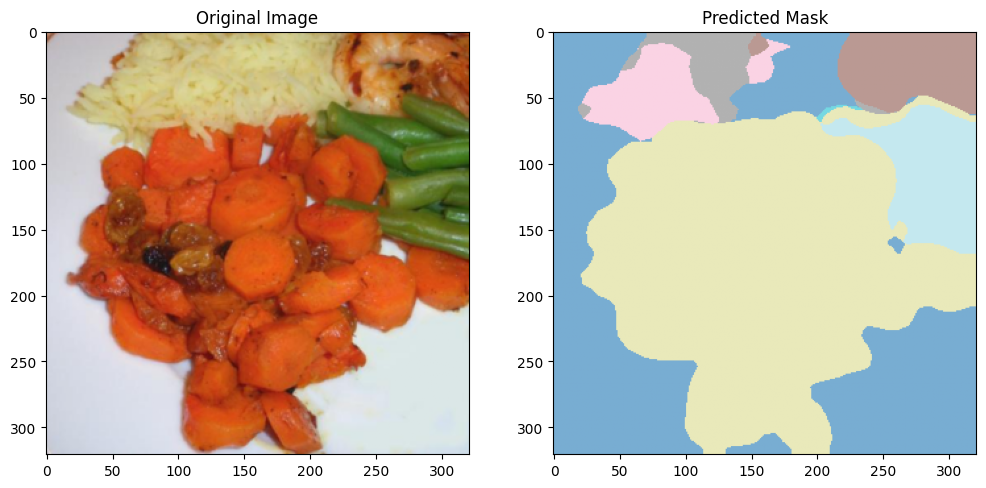

True food items:       ['French beans', 'rice', 'dried cranberries', 'carrot', 'shrimp']
Predicted food items:  ['French beans', 'rice', 'pie', 'potato', 'chicken duck', 'carrot', 'asparagus', 'broccoli']
Food Accuracy:        60.00%
Pixel Accuracy:       78.74%
Mean IoU:             25.57%
Mean Dice:            3.08%
Avg. Hausdorff Dist.: 63.36 pixels

Processing sample 2/10


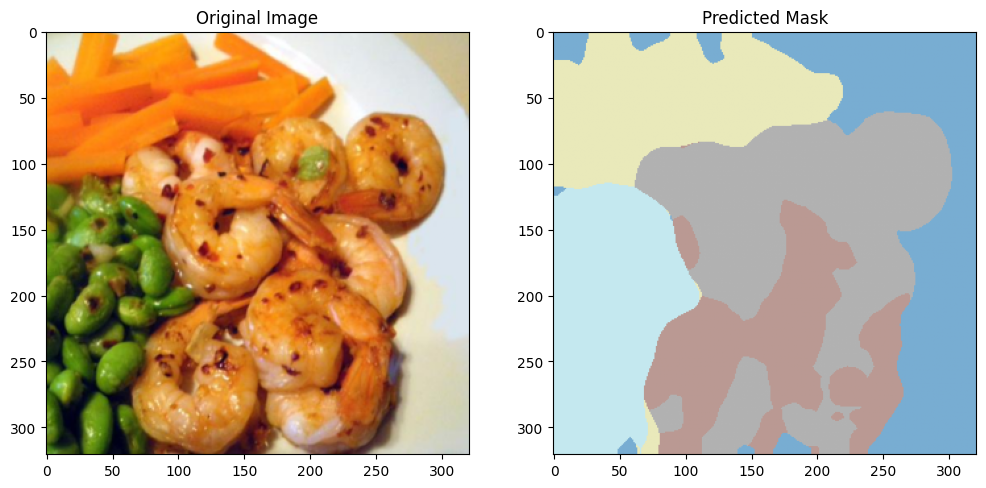

True food items:       ['shrimp', 'carrot', 'green beans']
Predicted food items:  ['potato', 'chicken duck', 'cucumber', 'carrot', 'asparagus', 'green beans']
Food Accuracy:        66.67%
Pixel Accuracy:       51.84%
Mean IoU:             34.37%
Mean Dice:            2.76%
Avg. Hausdorff Dist.: 9.50 pixels

Processing sample 3/10


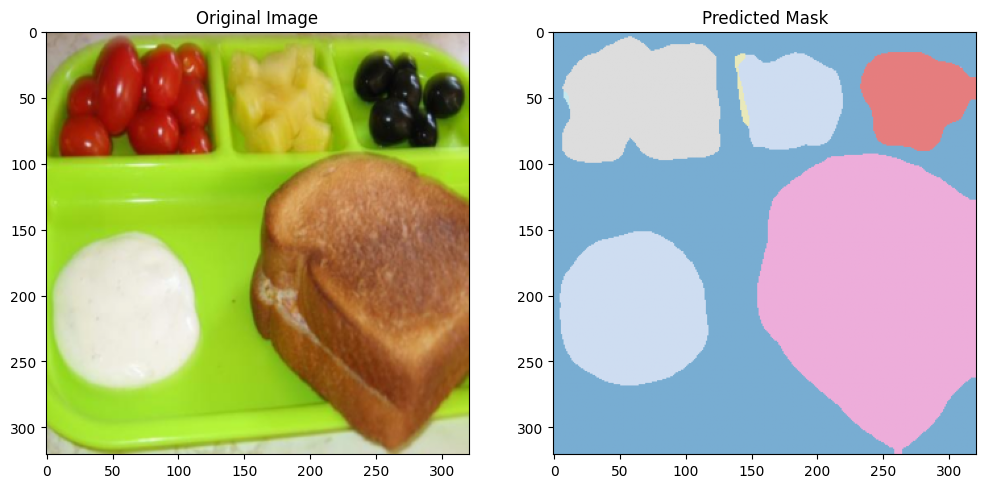

True food items:       ['olives', 'pineapple', 'tomato', 'sauce', 'bread']
Predicted food items:  ['blueberry', 'ice cream', 'grape', 'tomato', 'cucumber', 'bread', 'pepper']
Food Accuracy:        40.00%
Pixel Accuracy:       76.95%
Mean IoU:             25.04%
Mean Dice:            2.76%
Avg. Hausdorff Dist.: 9.52 pixels

Processing sample 4/10


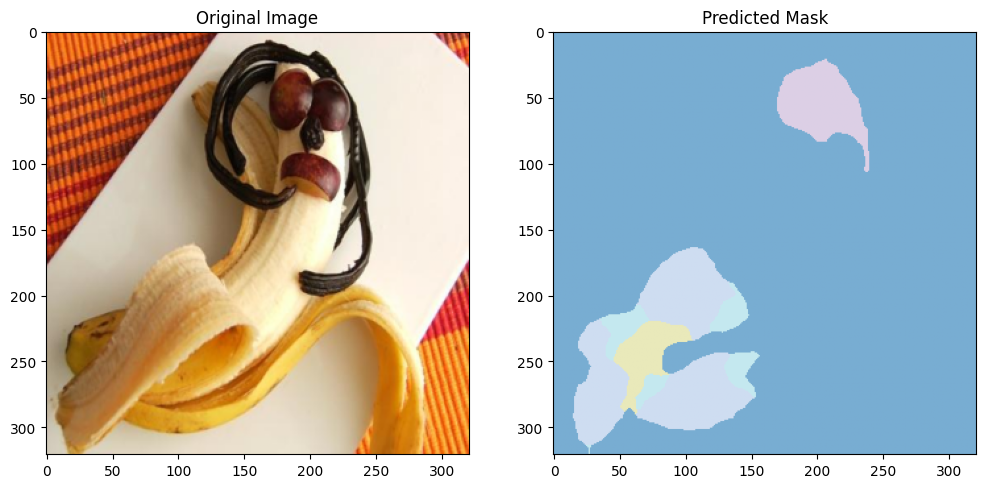

True food items:       ['grape', 'chocolate', 'banana']
Predicted food items:  ['blueberry', 'pie', 'biscuit', 'bread']
Food Accuracy:        0.00%
Pixel Accuracy:       58.72%
Mean IoU:             8.64%
Mean Dice:            0.79%
Avg. Hausdorff Dist.: nan pixels

Processing sample 5/10


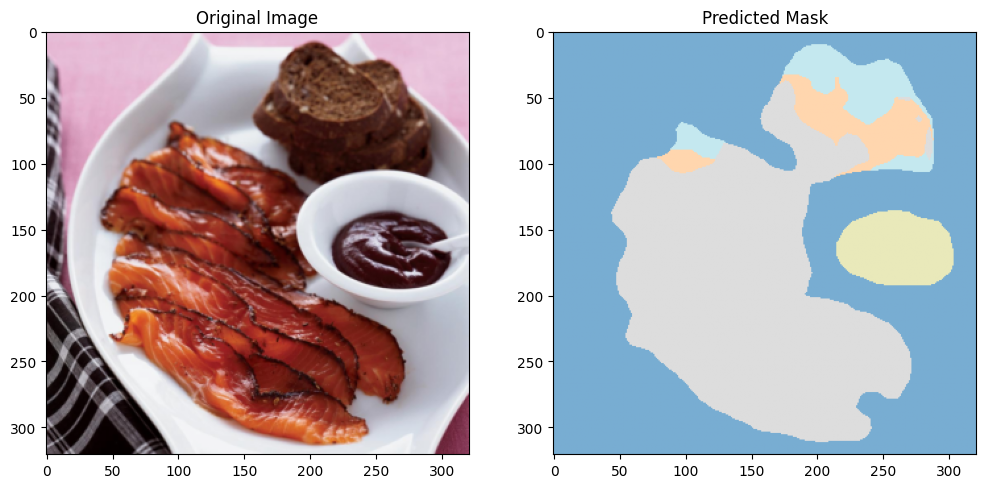

True food items:       ['bread', 'sauce', 'fish']
Predicted food items:  ['cake', 'steak', 'sauce', 'bread']
Food Accuracy:        66.67%
Pixel Accuracy:       60.16%
Mean IoU:             36.14%
Mean Dice:            2.31%
Avg. Hausdorff Dist.: 37.50 pixels

Processing sample 6/10


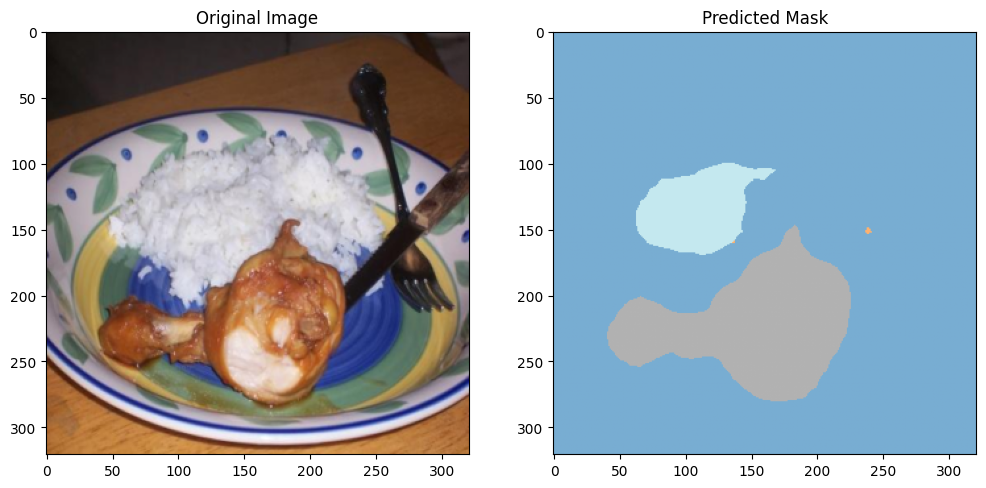

True food items:       ['chicken duck', 'rice']
Predicted food items:  ['ice cream', 'chicken duck', 'rice']
Food Accuracy:        100.00%
Pixel Accuracy:       87.44%
Mean IoU:             51.08%
Mean Dice:            2.22%
Avg. Hausdorff Dist.: 55.52 pixels

Processing sample 7/10


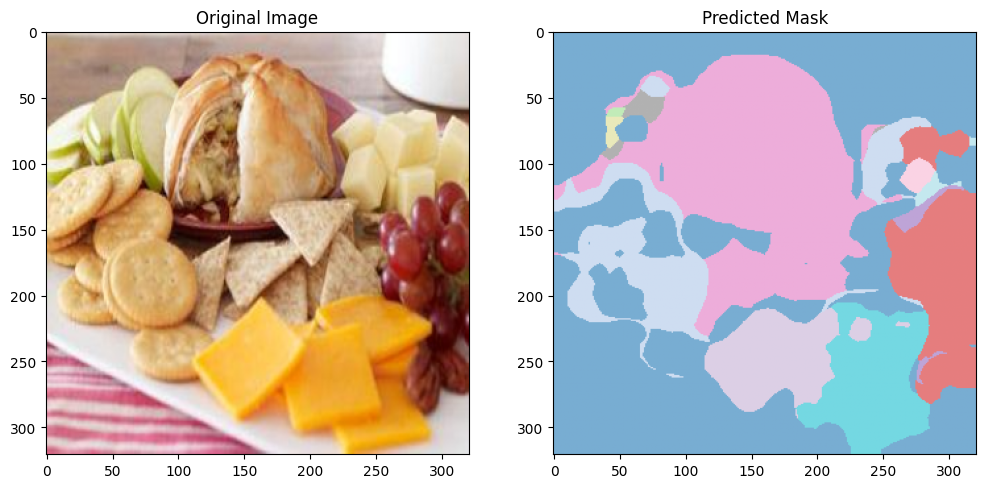

True food items:       ['biscuit', 'other ingredients', 'cheese butter', 'grape', 'apple', 'bread']
Predicted food items:  ['blueberry', 'noodles', 'french fries', 'pie', 'biscuit', 'grape', 'orange', 'cucumber', 'carrot', 'onion', 'egg', 'bread', 'banana', 'strawberry', 'cherry']
Food Accuracy:        50.00%
Pixel Accuracy:       49.33%
Mean IoU:             8.50%
Mean Dice:            2.01%
Avg. Hausdorff Dist.: 78.60 pixels

Processing sample 8/10


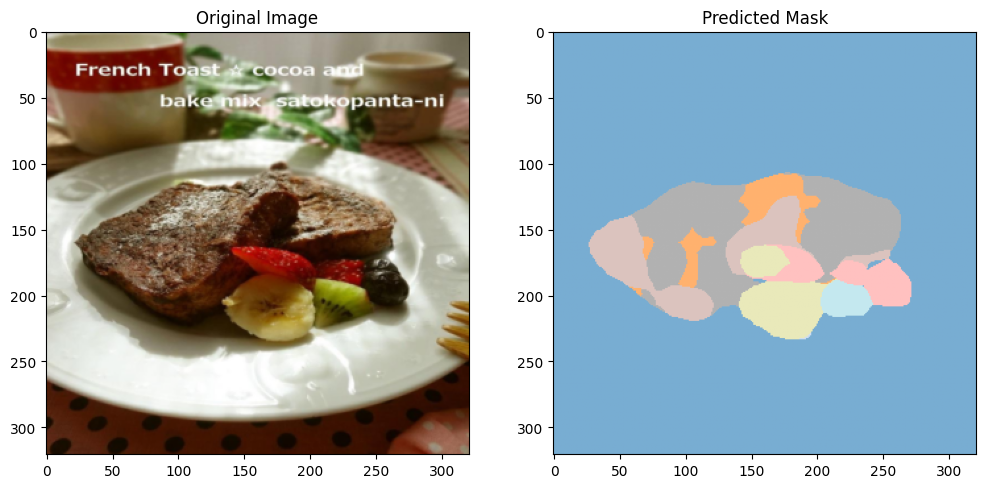

True food items:       ['blueberry', 'kiwi', 'bread', 'banana', 'strawberry']
Predicted food items:  ['blueberry', 'potato', 'ice cream', 'tomato', 'cake', 'steak', 'lettuce', 'cucumber', 'bread', 'strawberry']
Food Accuracy:        60.00%
Pixel Accuracy:       87.96%
Mean IoU:             21.09%
Mean Dice:            3.06%
Avg. Hausdorff Dist.: 22.66 pixels

Processing sample 9/10


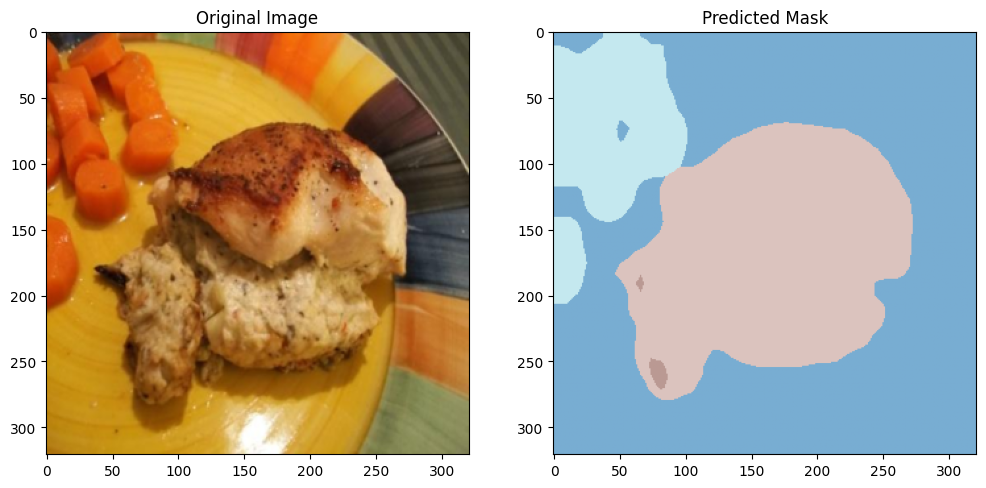

True food items:       ['chicken duck', 'carrot']
Predicted food items:  ['chicken duck', 'carrot', 'steak']
Food Accuracy:        100.00%
Pixel Accuracy:       96.17%
Mean IoU:             68.33%
Mean Dice:            2.75%
Avg. Hausdorff Dist.: 14.53 pixels

Processing sample 10/10


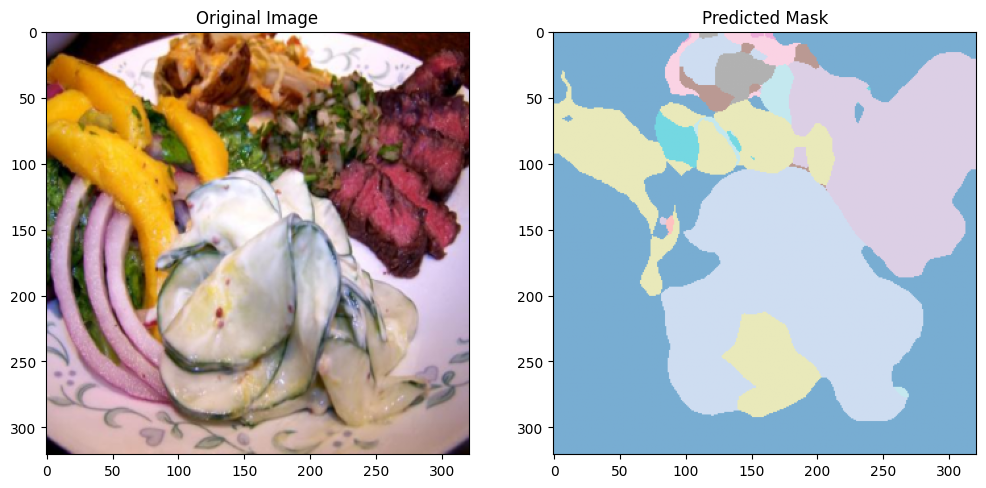

True food items:       ['shiitake', 'other ingredients', 'steak', 'cucumber', 'cilantro mint', 'onion']
Predicted food items:  ['french fries', 'biscuit', 'ice cream', 'lemon', 'orange', 'steak', 'chicken duck', 'sauce', 'bread', 'pie', 'potato', 'cucumber', 'carrot', 'asparagus', 'celery stick', 'cilantro mint', 'onion', 'pepper', 'French beans']
Food Accuracy:        66.67%
Pixel Accuracy:       38.49%
Mean IoU:             6.35%
Mean Dice:            1.69%
Avg. Hausdorff Dist.: 142.70 pixels

Processing sample 11/10


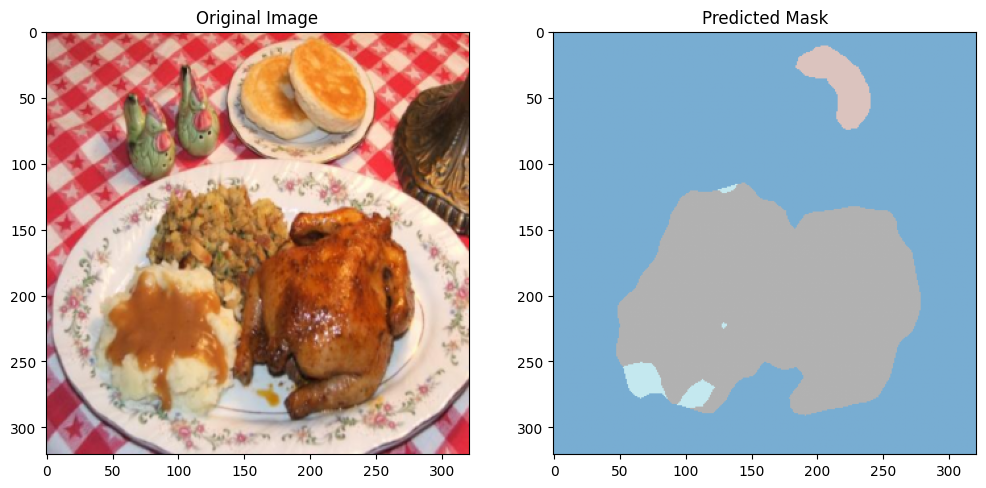

True food items:       ['chicken duck', 'pie', 'potato']
Predicted food items:  ['chicken duck', 'pie', 'lemon']
Food Accuracy:        66.67%
Pixel Accuracy:       84.13%
Mean IoU:             32.43%
Mean Dice:            1.71%
Avg. Hausdorff Dist.: 154.53 pixels

Processing sample 12/10


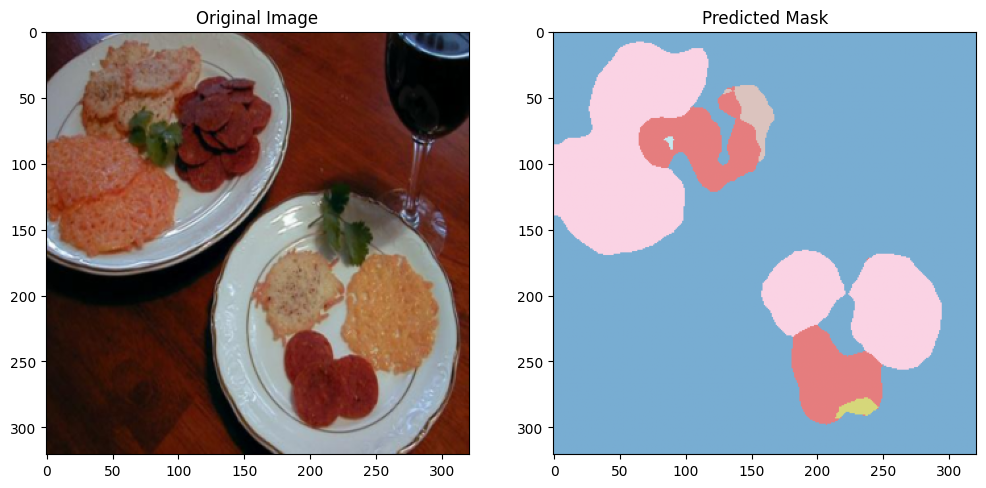

True food items:       ['pie', 'wine', 'sausage', 'cilantro mint']
Predicted food items:  ['tomato', 'sauce', 'cilantro mint', 'bread', 'strawberry', 'cherry']
Food Accuracy:        25.00%
Pixel Accuracy:       64.98%
Mean IoU:             8.98%
Mean Dice:            0.93%
Avg. Hausdorff Dist.: 173.08 pixels

Processing sample 13/10


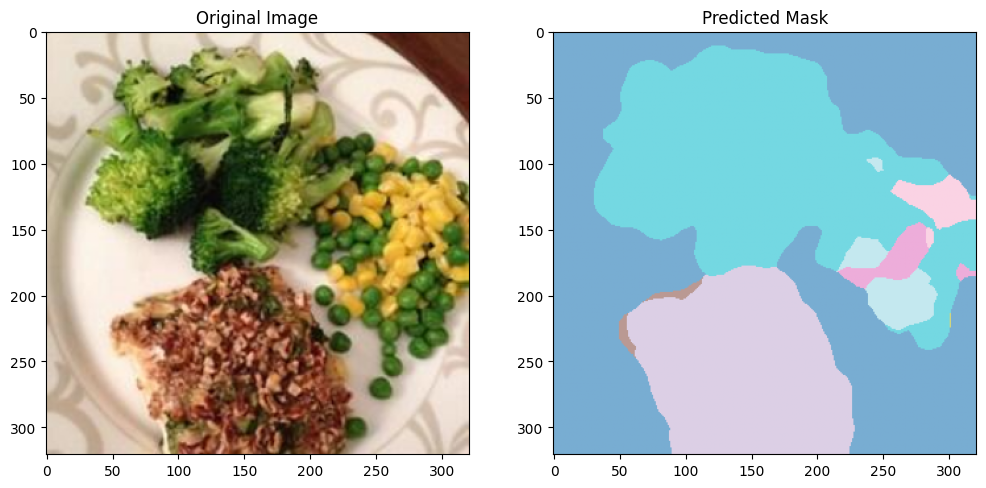

True food items:       ['fish', 'broccoli', 'corn', 'green beans']
Predicted food items:  ['pasta', 'rice', 'steak', 'chicken duck', 'lettuce', 'broccoli', 'cilantro mint', 'corn', 'green beans']
Food Accuracy:        75.00%
Pixel Accuracy:       67.39%
Mean IoU:             18.63%
Mean Dice:            2.38%
Avg. Hausdorff Dist.: 75.53 pixels

Processing sample 14/10


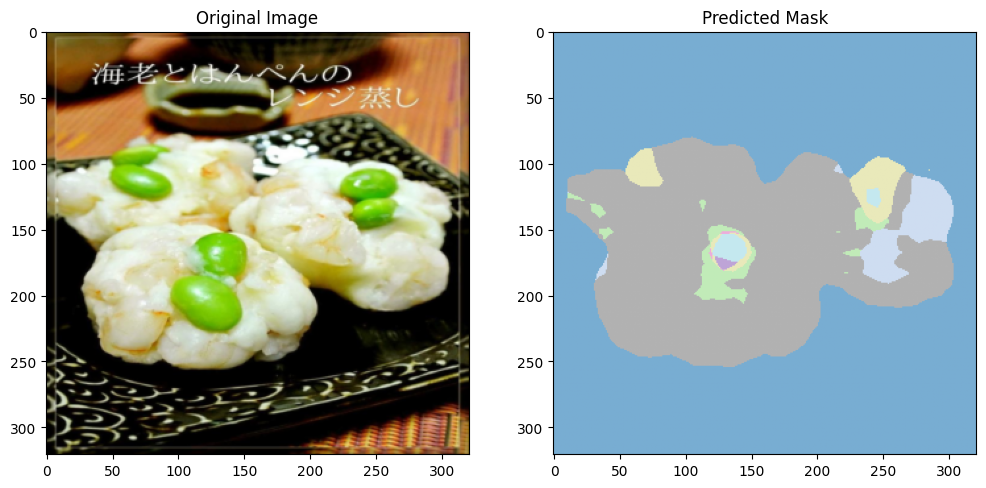

True food items:       ['shrimp', 'green beans']
Predicted food items:  ['pie', 'potato', 'ice cream', 'grape', 'cucumber', 'egg', 'corn', 'green beans']
Food Accuracy:        50.00%
Pixel Accuracy:       62.43%
Mean IoU:             10.40%
Mean Dice:            1.10%
Avg. Hausdorff Dist.: 99.20 pixels

Processing sample 15/10


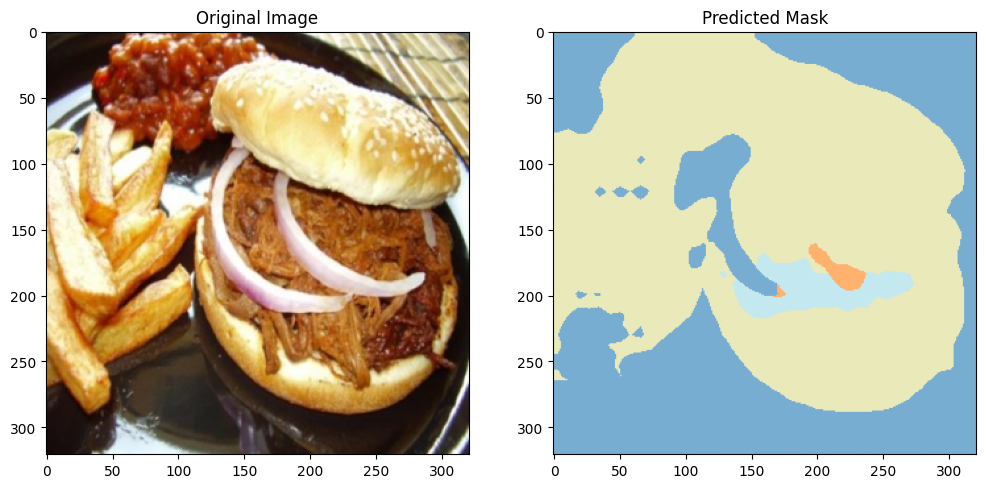

True food items:       ['french fries', 'steak', 'sauce', 'bread', 'onion']
Predicted food items:  ['french fries', 'pie', 'ice cream', 'bread']
Food Accuracy:        40.00%
Pixel Accuracy:       53.18%
Mean IoU:             17.16%
Mean Dice:            1.65%
Avg. Hausdorff Dist.: 94.40 pixels

Processing sample 16/10


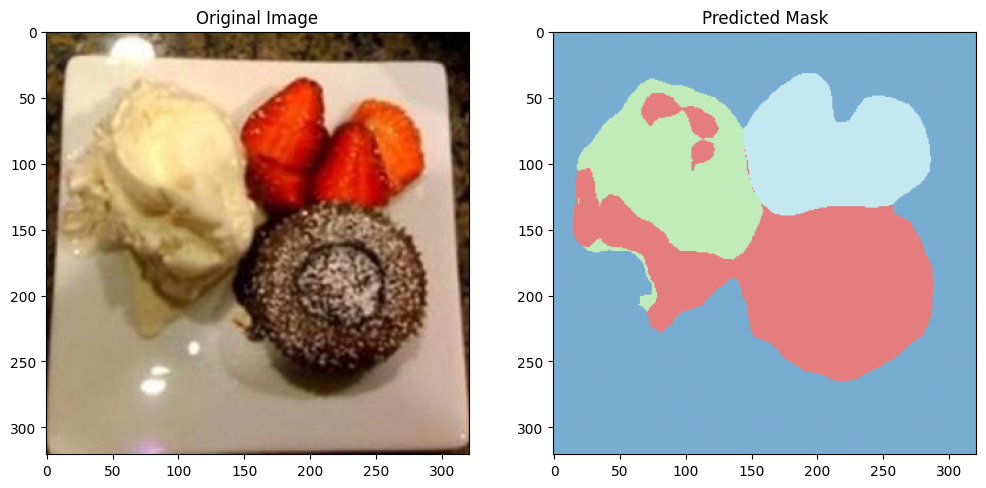

True food items:       ['ice cream', 'cake', 'strawberry']
Predicted food items:  ['ice cream', 'cake', 'strawberry']
Food Accuracy:        100.00%
Pixel Accuracy:       90.74%
Mean IoU:             78.25%
Mean Dice:            3.34%
Avg. Hausdorff Dist.: 62.46 pixels

Processing sample 17/10


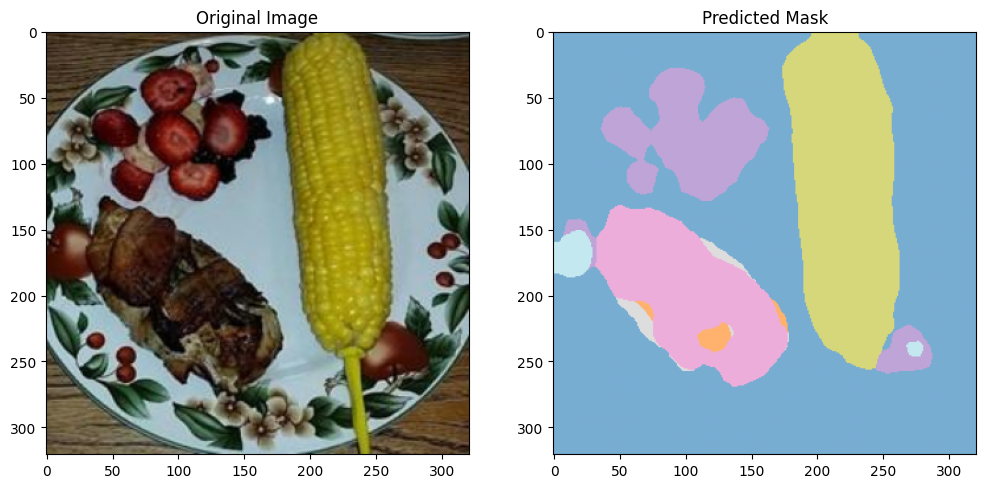

True food items:       ['raspberry', 'pork', 'chicken duck', 'corn', 'banana', 'strawberry']
Predicted food items:  ['blueberry', 'tomato', 'cake', 'steak', 'bread', 'corn', 'strawberry', 'cherry']
Food Accuracy:        33.33%
Pixel Accuracy:       79.99%
Mean IoU:             18.64%
Mean Dice:            2.55%
Avg. Hausdorff Dist.: 111.02 pixels

Processing sample 18/10


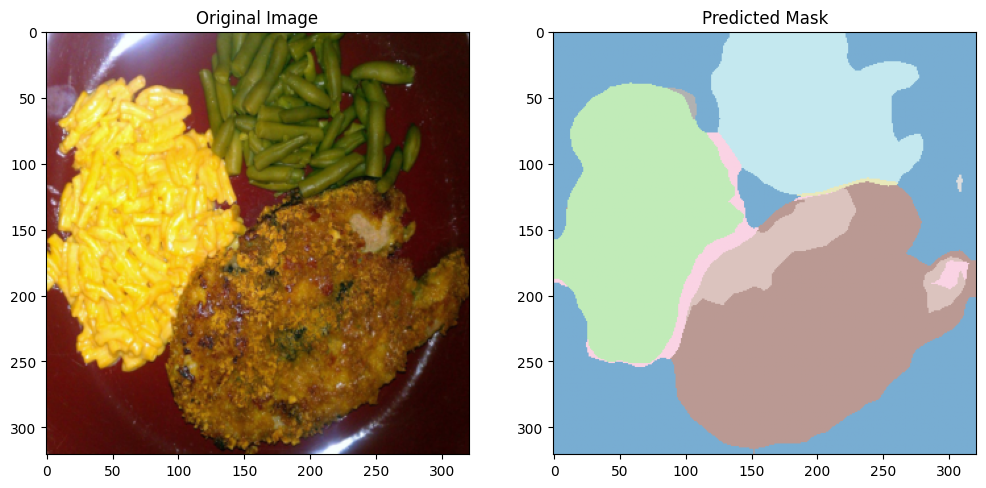

True food items:       ['pasta', 'French beans', 'pork']
Predicted food items:  ['noodles', 'French beans', 'pie', 'potato', 'tomato', 'chicken duck', 'sauce', 'asparagus', 'fish', 'egg']
Food Accuracy:        33.33%
Pixel Accuracy:       46.43%
Mean IoU:             14.04%
Mean Dice:            1.84%
Avg. Hausdorff Dist.: 10.00 pixels

Processing sample 19/10


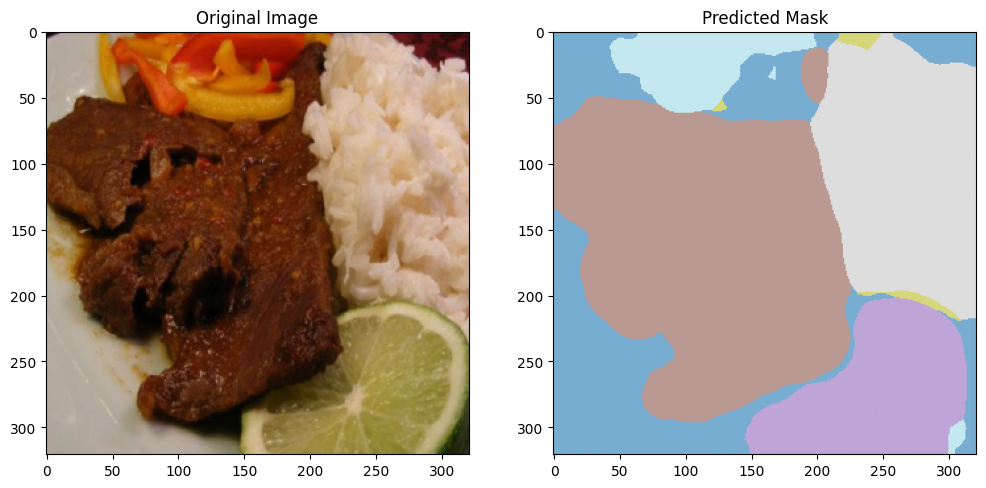

True food items:       ['rice', 'lemon', 'chicken duck', 'pepper']
Predicted food items:  ['rice', 'lemon', 'potato', 'tomato', 'steak', 'cucumber', 'carrot']
Food Accuracy:        50.00%
Pixel Accuracy:       46.91%
Mean IoU:             24.75%
Mean Dice:            2.60%
Avg. Hausdorff Dist.: 20.46 pixels

Processing sample 20/10


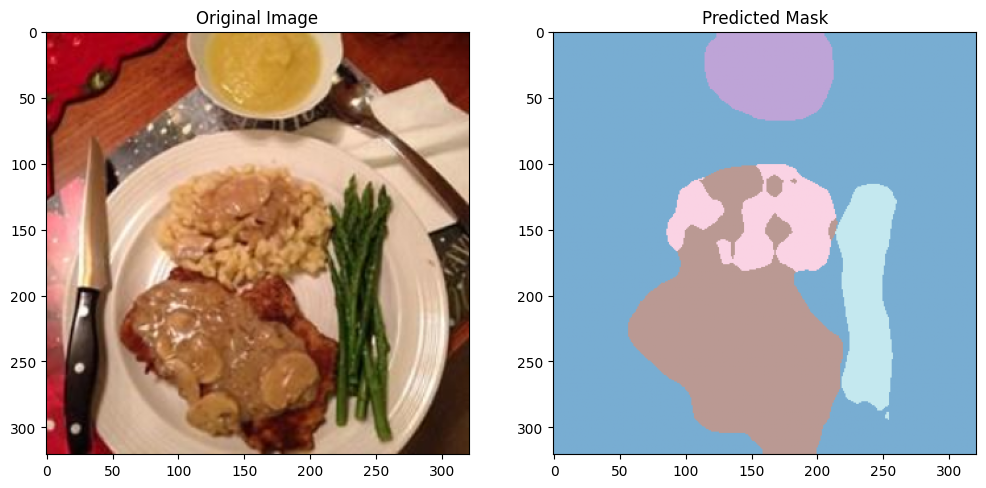

True food items:       ['white button mushroom', 'steak', 'sauce', 'asparagus', 'egg']
Predicted food items:  ['pie', 'lemon', 'steak', 'chicken duck', 'asparagus', 'cilantro mint', 'bread']
Food Accuracy:        40.00%
Pixel Accuracy:       76.41%
Mean IoU:             17.69%
Mean Dice:            2.16%
Avg. Hausdorff Dist.: 77.60 pixels


In [ ]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from matplotlib.colors import ListedColormap
import torch.nn as nn
from pyarrow.parquet import ParquetFile
from scipy.spatial.distance import directed_hausdorff

# Hyperparameters
HYPERPARAMS = {
    "img_size": (321, 321),   # Use the same image size as in training.
    "num_classes": 104,       # Number of segmentation classes.
}


# Loads the class mappings CSV
class_mappings = pd.read_csv('/content/foodseg103/class_mappings.csv')
id_to_food = dict(zip(class_mappings["Class Id"], class_mappings["Class Name"]))


def load_model():

# Loads the saved deeplab model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)
    model.classifier[4] = nn.Conv2d(256, HYPERPARAMS["num_classes"], kernel_size=1)

    state_dict = torch.load("/content/foodseg103/deeplabv3_resnet50_foodseg103.pth", map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    return model, device




# Transforms the images in the same way as during training
img_transform = transforms.Compose([
    transforms.Resize(HYPERPARAMS["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Function to calculate performance metrics such as Iou and DSC
def compute_segmentation_metrics(pred, target, num_classes):
    pred = pred.flatten()
    target = target.flatten()
    pixel_acc = np.mean(pred == target)

    iou_list = []
    dice_list = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = np.sum(pred_inds & target_inds)
        union = np.sum(pred_inds | target_inds)
        # For IoU, if there is no ground truth and prediction for this class, skip it.
        if union == 0:
            iou = np.nan
        else:
            iou = intersection / union
        iou_list.append(iou)
        dice = (2 * intersection) / (np.sum(pred_inds) + np.sum(target_inds) + 1e-8)
        dice_list.append(dice)

    mean_iou = np.nanmean(iou_list)
    mean_dice = np.nanmean(dice_list)
    return pixel_acc, mean_iou, mean_dice

#Calculates the hausdorff distance for a specific class
def hausdorff_distance_for_class(pred, target, cls):
    pred_points = np.argwhere(pred == cls)
    target_points = np.argwhere(target == cls)
    if pred_points.size == 0 or target_points.size == 0:
        return np.nan
    d1 = directed_hausdorff(pred_points, target_points)[0]
    d2 = directed_hausdorff(target_points, pred_points)[0]
    return max(d1, d2)

def compute_average_hausdorff(pred, target, num_classes):
    hd_list = []
    for cls in range(1, num_classes):  # skip class 0 as it is the background
        hd = hausdorff_distance_for_class(pred, target, cls)
        if not np.isnan(hd):
            hd_list.append(hd)
    if hd_list:
        return np.mean(hd_list)
    else:
        return np.nan

# Streams the validation data from the parquet file
def stream_validation_data():
    pf = ParquetFile("/content/foodseg103/validation-00000-of-00001-a5bfdaa5beb7006a.parquet")
    return pf.iter_batches(batch_size=1)

def process_image(batch, model, device, id_to_food):
    #Load and process the image
    image_bytes = batch['image'][0].as_py()['bytes']
    img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    img_transformed = img_transform(img)  # [C, H, W]

    #Load and process the ground-truth segmentation mask
    label_bytes = batch['label'][0].as_py()['bytes']
    label_img = Image.open(io.BytesIO(label_bytes))
    #Resize the segmentation mask using nearest neighbor interpolation to preserve class indices.
    label_img = label_img.resize(HYPERPARAMS["img_size"], resample=Image.NEAREST)
    gt_mask = np.array(label_img)

    # For reporting true food items, we extract the unique class IDs from the ground truth.
    true_ids = set(np.unique(gt_mask))
    if 0 in true_ids:
        true_ids.remove(0)
    true_foods = [id_to_food.get(fid, "Unknown") for fid in true_ids if fid in id_to_food]

    #Model inference
    input_tensor = img_transformed.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)['out']
        pred_mask = output[0].argmax(0).cpu().numpy()

    #Extract predicted food items
    pred_ids = set(np.unique(pred_mask))
    if 0 in pred_ids:
        pred_ids.remove(0)
    predicted_foods = [id_to_food.get(pid, "Unknown") for pid in pred_ids if pid in id_to_food]

    #Computes accuracy as a percentage of true food items that are present in the predicted mask
    #(Needs to be changed to punish accuracy when the model predicts food items not present in the ground truth)
    if true_ids:
        correct = len(true_ids.intersection(pred_ids))
        food_accuracy = (correct / len(true_ids)) * 100.0
    else:
        food_accuracy = 0.0

    #Compute segmentation metrics
    pixel_acc, mean_iou, mean_dice = compute_segmentation_metrics(pred_mask, gt_mask, HYPERPARAMS["num_classes"])
    avg_hausdorff = compute_average_hausdorff(pred_mask, gt_mask, HYPERPARAMS["num_classes"])

    return {
        "image": img,
        "image_tensor": img_transformed,
        "mask": pred_mask,
        "gt_mask": gt_mask,
        "true_foods": true_foods,
        "predicted_foods": predicted_foods,
        "food_accuracy": food_accuracy,
        "pixel_acc": pixel_acc,
        "mean_iou": mean_iou,
        "mean_dice": mean_dice,
        "avg_hausdorff": avg_hausdorff
    }


def main():
    model, device = load_model()
    val_stream = stream_validation_data()
    # Creates a colormap for better visualization
    cmap = ListedColormap(plt.cm.tab20.colors[:HYPERPARAMS["num_classes"]])

    # Process the first 10 samples.
    for i, batch in enumerate(val_stream):
        if i >= 20:
            break

        print(f"\nProcessing sample {i+1}/10")
        results = process_image(batch, model, device, id_to_food)

        #Denormalize the image for display
        img_tensor = results["image_tensor"]
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_denorm = img_tensor * std + mean
        img_np = img_denorm.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)

        #Visualization
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(img_np)
        ax[0].set_title("Original Image")
        ax[1].imshow(results["mask"], cmap=cmap, alpha=0.6)
        ax[1].set_title("Predicted Mask")
        plt.show()

        #Print Results
        print("True food items:      ", results["true_foods"])
        print("Predicted food items: ", results["predicted_foods"])
        print(f"Food Accuracy:        {results['food_accuracy']:.2f}%")
        print(f"Pixel Accuracy:       {results['pixel_acc']*100:.2f}%")
        print(f"Mean IoU:             {results['mean_iou']*100:.2f}%")
        print(f"Mean Dice:            {results['mean_dice']*100:.2f}%")
        print(f"Avg. Hausdorff Dist.: {results['avg_hausdorff']:.2f} pixels")

if __name__ == "__main__":
    main()


In [ ]:
!xxd /content/foodseg103/deeplabv3_resnet50_foodseg103.pth | head

00000000: ca5c 08ba 5226 f8bb 30bf 8c3b 7284 ee3a  .\..R&..0..;r..:
00000010: 4b08 363a 9c5a 0dbc d7df bc3b 4bc1 04bc  K.6:.Z.....;K...
00000020: 48ad 71bb c612 e13b 30ae 0f39 6c4f 00bc  H.q....;0..9lO..
00000030: 7648 0d3c d012 a6bb 005a ab3a 033a b739  vH.<.....Z.:.:.9
00000040: 5ad2 943c b9fb 4d3a 1d7d eabb 2cfd 87b9  Z..<..M:.}..,...
00000050: 92cf 9ebc edb0 ddba 9393 483b 6106 b03b  ..........H;a..;
00000060: 1f9c ef3a 2843 63bb 85f3 82ba 7268 ddbb  ...:(Cc.....rh..
00000070: ab01 adbb 9c31 ea3a b271 f23a 69ef 14bc  .....1.:.q.:i...
00000080: bd75 15bc c581 5c3c cc97 ffbb 5df0 b2ba  .u....\<....]...
00000090: 2806 6339 07bd 78bc a957 233b 4bcd d63b  (.c9..x..W#;K..;
